# QVA, RV 전처리
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## [1] 함수 정리
---

In [2]:
def connect_year_month(data: pd.DataFrame, year: str, month: str, is_num=True):
    """connect year and month column to datetime
    Args:
        data (pd.DataFrame): dataframe
        year (str): year column name
        month (str): month column name

    Returns:
        pd.DataFrame: dataframe
    """
    data_c = data.copy()
    data_c[year] = data_c[year].astype(str)
    data_c[month] = data_c[month].astype(str)

    if is_num == False:
        if data_c[year].iloc[0][-1] == "년":
            data_c[year] = data_c[year].str[:-1]
        if data_c[month].iloc[0][-1] == "월":
            data_c[month] = data_c[month].str[:-1]

    data_c[year] = data_c[year] + "-" + data_c[month]
    data_c[year] = pd.to_datetime(data_c[year])
    data_c.drop(columns=month, inplace=True)
    data_c.rename(columns={year: "DATE"}, inplace=True)

    return data_c

## [2] 데이터 로딩
---

In [3]:
data_qva = pd.read_csv("./raw-data/Data_Qva.csv")
data_rv = pd.read_csv("./raw-data/Data_Rv.csv")

In [4]:
data_qva.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   YEAR     100 non-null    int64  
 1   QUARTER  100 non-null    object 
 2   Value    100 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.5+ KB


In [5]:
data_rv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   YEAR               300 non-null    int64  
 1   MONTH              300 non-null    int64  
 2   RV                 300 non-null    float64
 3   GAS                300 non-null    float64
 4   OTHER OIL PRODUCT  300 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 11.8 KB


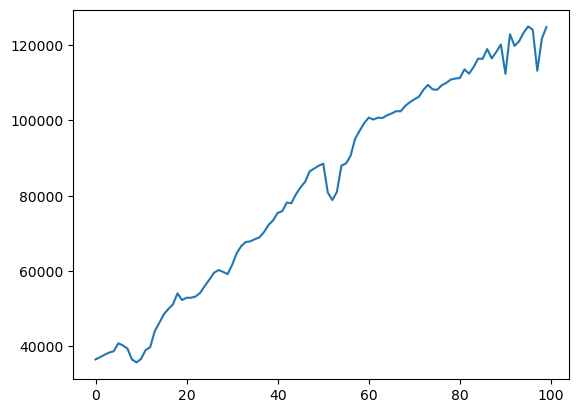

In [9]:
# 데이터 체크
plt.plot(data_qva["Value"]);

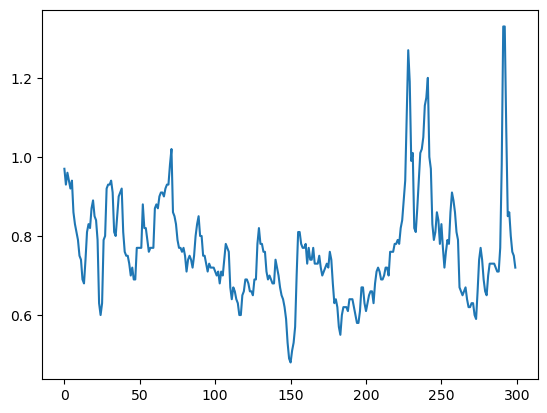

In [10]:
plt.plot(data_rv["RV"]);

## [3] 데이터 전처리
---

### [3-1] 데이터 컬럼명 정리

In [11]:
qva_cols = ["YEAR", "QUARTER", "QVA"]
rc_cols = ["YEAR", "MONTH", "RV", "GAS_PRICE_IND", "OIL_PRICE"]

data_qva.columns = qva_cols
data_rv.columns = rc_cols

### [3-2] 데이터 타임 전처리

In [12]:
# 상대가격 데이터 데이트타임
data_rv_con = connect_year_month(data_rv, year="YEAR", month="MONTH")
data_rv_con

,DATE,RV,GAS_PRICE_IND,OIL_PRICE
0,1996-01-01,0.97,26.94,27.86
1,1996-02-01,0.93,26.94,29.04
2,1996-03-01,0.96,26.94,27.99
3,1996-04-01,0.94,26.94,28.74
4,1996-05-01,0.92,26.94,29.18
...,...,...,...,...
295,2020-08-01,0.86,72.93,84.71
296,2020-09-01,0.80,65.24,81.26
297,2020-10-01,0.76,59.16,78.13
298,2020-11-01,0.75,58.72,78.64


In [13]:
# 제조업가치 분기를 데이트타임으로 변경
data_qva.head()

,YEAR,QUARTER,QVA
0,1996,Q1,36550.3
1,1996,Q2,37152.4
2,1996,Q3,37792.4
3,1996,Q4,38372.4
4,1997,Q1,38710.8


In [14]:
# 월별 데이터와 쿼터별 데이터 생성
date_range = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
quarter_range = pd.date_range("1996-01-01", "2020-12-01", freq="QS")

data_date = pd.DataFrame({"DATE" :date_range.to_list()})
data_quarter = pd.DataFrame({"DATE" :quarter_range.to_list()})

In [15]:
# QVA값 입력하기
QVA = data_qva["QVA"]
data_quarter["QVA"] = QVA
data_date["QVA"] = np.NAN

# 인덱스 시간으로 변경
data_quarter.set_index("DATE", inplace=True)
data_date.set_index("DATE", inplace=True)

In [16]:
# 데이터 합치고 컬럼 하나 드롭하기
data_full = pd.concat([data_quarter, data_date], axis=1)
data_full.columns = ["QVA", "drop"]
data_final = data_full.drop(columns="drop")

### [3-3] 결측치 처리

In [17]:
data_interploate = data_final.interpolate()
data_ffill = data_final.fillna(method="ffill")

### [3-4] 인덱스 리셋

In [18]:
data_interploate.reset_index(inplace=True)
data_ffill.reset_index(inplace=True)

## [4] 데이터 저장
---

In [19]:
data_rv_con.to_csv("data_rv.csv", index=False)
data_interploate.to_csv("data_qva_inter.csv", index=False)
data_ffill.to_csv("data_qva_ff.csv", index=False)